In [2]:
import pandas as pd

import numpy as np
import sys, os
import scipy.stats
import collections
import math
import statistics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1

matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2.5
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.width'] = 1

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# function to change width
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # change the bar width
        patch.set_width(new_value)
        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [3]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.array_equal(l.get_xdata(), [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [28]:
# import splicing measurements
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

# for each reporter, retrieve the most abundant isoform
primary_isoform = HELA.set_index('RE').iloc[:, 1:-2].idxmax(axis = 1).to_frame(name = 'isoform').reset_index()
HELA = HELA.merge(primary_isoform, on = 'RE')
HELA = HELA[['RE', 'full_length', 'isoform', 'spliced_fraction']].rename(columns = {'full_length': 'FL_fraction'})

def replace_FL_isoform(FL_fraction, isoform):
    if FL_fraction > 0.99:
        return 'full_length'
    else:
        return isoform
    
HELA['isoform'] = HELA.apply(lambda g: replace_FL_isoform(g['FL_fraction'], g['isoform']), axis = 1)

In [29]:
# read summary of spliceAI prediction
# see get_best_site.py script on cluster for details on how to generate the file
spliceai = pd.read_csv('data/spliceai_full_transcript_prediction_best_sites.txt', sep = '\t')
medspliceai = spliceai.groupby('plasmid').agg({'best_donor': pd.Series.mode,
                                               'donor_prob': 'median',
                                               'best_acceptor': pd.Series.mode,
                                              'acceptor_prob': 'median'}).reset_index()

def replace_site(d, a):
    if type(d) is np.ndarray:
        donor = d[-1]
    else:
        donor = d
        
    if type(a) is np.ndarray:
        acceptor = a[-1]
    else:
        acceptor = a
        
    return donor, acceptor

medspliceai['best_donor'], medspliceai['best_acceptor'] = zip(*medspliceai.apply(lambda g: 
                                                                            replace_site(g['best_donor'],
                                                                                        g['best_acceptor']), 
                                                                                 axis = 1))

In [30]:
# merge measured splicing percentage with spliceAI prediction
m = HELA.merge(medspliceai, left_on = 'RE', right_on = 'plasmid')

# combine donor and acceptor probability
def calculate_splice_prob(d, a):
    return d*a

m['splicing_prob'] = m.apply(lambda g: calculate_splice_prob(g['donor_prob'], g['acceptor_prob']), axis = 1)

## Figure 5A: spliceAI probability is positivly correlated with PTRE-seq splicing measurements

Text(0, 0.5, 'splicing efficiency')

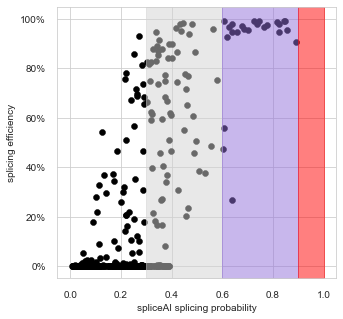

In [31]:
f, ax = plt.subplots(figsize = (5, 5))

sns.scatterplot(
    data = m, 
    x = 'splicing_prob', 
    y = 'spliced_fraction', 
    color = 'black',
    edgecolor = None,
    ax = ax)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.fill_between([0.3, 0.6], -0.05, 1.05, color = 'lightgrey', alpha = 0.5)
ax.fill_between([0.6, 0.9], -0.05, 1.05, color = 'mediumpurple', alpha = 0.5)
ax.fill_between([0.9, 1.0], -0.05, 1.05, color = 'red', alpha = 0.5)

ax.set_xlabel('spliceAI splicing probability')
ax.set_ylabel('splicing efficiency')

#f.savefig('Figures_ver3/Figure_7_scatterplot_spliceprob_fraction.pdf', transparent = True)

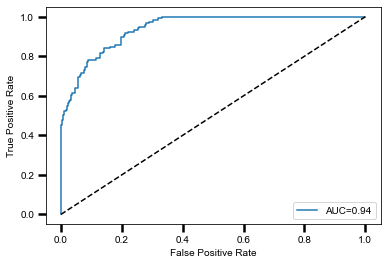

In [18]:
# Plot ROC curve for product classifier

f, ax = plt.subplots()

# assess performace of several predictors using ROC and AUC
def classify_threshold(joint, upper, lower):
    if joint >= upper:
        return 1
    elif joint <= lower:
        return 0
    else:
        return np.nan
    
m['threshold_20'] = m['spliced_fraction'].apply(lambda g: classify_threshold(g, 0.2, 0.2))

# calculate AUC values for all predictors vs measured splicing fraction
df2 = m.dropna(subset = ['threshold_20'])
AUC_dict = {}

df2 = m.dropna(subset = ['threshold_20'])
lr_probs = df2['splicing_prob']
testy = df2['threshold_20']
# calculate scores
lr_auc = roc_auc_score(testy, lr_probs)
AUC_dict['threshold_20'] = lr_auc
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot
label = f'AUC={lr_auc:.2f}'
ax.plot(lr_fpr, lr_tpr, label=label)

ns_probs = [0]*len(df2)
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', color = 'black')

# show the legend
pyplot.legend(loc = 'lower right')
    
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc = 'lower right')

#f.savefig('Figures_ver3/heatmap_AUC_values.pdf', transparent = True)

## Evaluate published MPRAs

### Import Griesemer MPRA results

In [25]:
# Import splicing prediction results
griesemer_splice = pd.read_csv('data/griesemer_spliceai_prediction.csv', sep = '\t')

# Import measurements from original publication
griesemer_result = pd.read_excel('data/griesemer_expression_measurements.xlsx', sheet_name = 'Variant MPRAu Results')

# parse spliceai
def changename(seqid):
    if 'ref' in seqid:
        seqid = seqid.replace('_ref', '') + '_ref'
        mpra_variant_id = seqid.replace('_ref', '')
        allele = 'ref'
    elif 'alt' in seqid:
        seqid = seqid.replace('_alt', '') + '_alt'
        mpra_variant_id = seqid.replace('_alt', '')
        allele = 'alt'
    else:
        mpra_variant_id = seqid
        allele = np.nan
        
    return seqid, mpra_variant_id, allele
        
griesemer_splice['name'], griesemer_splice['mpra_variant_id'], griesemer_splice['allele'] = zip(
    *griesemer_splice[
    'seq_id'
].apply(
    lambda g: changename(g)
)
                                                          )

# parse result
gresult = pd.melt(griesemer_result, id_vars = 'mpra_variant_id', var_name = 'allele', value_name = 'log2FoldChange', 
        value_vars = ['log2FoldChange_Ref_HEK293FT', 'log2FoldChange_Alt_HEK293FT'])

def combine_name(seqid, allele):
    if 'Ref' in allele:
        return seqid + '_ref'
    elif 'Alt' in allele:
        return seqid + '_alt'
    
gresult['name'] = gresult.apply(lambda g: combine_name(g['mpra_variant_id'], g['allele']), axis = 1)

# combine spliceai and result
griesemer = griesemer_splice.merge(gresult, on = 'name', how = 'outer')
griesemer = griesemer.dropna(subset = ['seq_id'])

### Siegel MPRA

In [32]:
# import splicing prediction
siegel = pd.read_csv('data/siegel_spliceai_prediction.csv', sep = '\t')

# import expression measurements from jurkat cell lines
siegel_jurkat = pd.read_csv('data/siegel_expression_measurements_jurkat.csv')
temp = siegel_jurkat.reset_index()
temp['seq_id'] = temp.apply(lambda g: g['region']+'_'+str(g['index']), axis = 1)

# merge splicing and expression 
siegel = siegel.merge(temp, on = 'seq_id')

"""
siegel_beas2b = pd.read_csv('../splicing_stuffs/other_mpras/siegel_result_beas2b.csv')
temp = beas2b.reset_index()
temp['seq_id'] = temp.apply(lambda g: g['region']+'_'+str(g['index']), axis = 1)
m = m.merge(temp, on = 'seq_id', suffixes = ('_jurkat', '_beas2b'))"""

"\nsiegel_beas2b = pd.read_csv('../splicing_stuffs/other_mpras/siegel_result_beas2b.csv')\ntemp = beas2b.reset_index()\ntemp['seq_id'] = temp.apply(lambda g: g['region']+'_'+str(g['index']), axis = 1)\nm = m.merge(temp, on = 'seq_id', suffixes = ('_jurkat', '_beas2b'))"

### Zhao MPRA

In [33]:
# import splicing prediction
zhao = pd.read_csv('data/zhao_spliceai_prediction.csv', sep = '\t')

# import expression measurements
zhao_beas2b = pd.read_excel('data/zhao_expression_measurements.xls', skiprows = 5)

# merge
zhao = zhao.merge(zhao_beas2b, left_on = 'seq_id', right_on = 'segment_id')

zhao = zhao.replace('nd', np.nan)

## Figure 5C: percent of reporters predicted to be spliced

In [34]:
# add probability bins 
def prediction(prob):
    if prob <= 0.30:
        return '0-0.30'
    elif prob <= 0.60:
        return '0.30-0.60'
    elif prob <= 0.90:
        return '0.60-0.90'
    else:
        return '0.90-1.00'
    
# For Griesemer MPRA
griesemer['prediction'] = griesemer['probability'].apply(lambda g: prediction(g))
toplot1 = griesemer[['prediction', 'log2FoldChange']].reset_index(drop=True)
toplot1['mpra'] = 'griesemer'

# For Siegel MPRA
siegel['prediction'] = siegel['probability'].apply(lambda g: prediction(g))
siegel_median = siegel['ratios_T0_GC_resid'].median() # Use ratios_T0 as measurement, adjusted for GC content
siegel['log2FoldChange'] = siegel['ratios_T0_GC_resid'].apply(lambda g: np.log2(g/siegel_median))
toplot2 = siegel[['prediction', 'log2FoldChange']].reset_index(drop=True)
toplot2 = toplot2[~toplot2['log2FoldChange'].isin([-np.inf])]
toplot2['mpra'] = 'siegel'

# For Zhao MPRA
zhao['prediction'] = zhao['probability'].apply(lambda g: prediction(g))
zhao['log2FoldChange'] = zhao['BEAS-2B log2 steady state mRNA']
toplot3 = zhao[['prediction', 'log2FoldChange']].reset_index(drop=True)
toplot3['mpra'] = 'zhao'

toplot = pd.concat([toplot1, toplot2, toplot3])

        mpra prediction  count  fraction
3  griesemer  0.30-0.60   6616  0.153024
5     siegel  0.30-0.60   2300  0.055756
9       zhao  0.30-0.60    181  0.064875
         mpra prediction  count  fraction
1   griesemer  0.60-0.90   7231  0.167249
6      siegel  0.60-0.90    982  0.023805
10       zhao  0.60-0.90     84  0.030108
         mpra prediction  count  fraction
2   griesemer  0.90-1.00   7020  0.162368
7      siegel  0.90-1.00    169  0.004097
11       zhao  0.90-1.00      5  0.001792


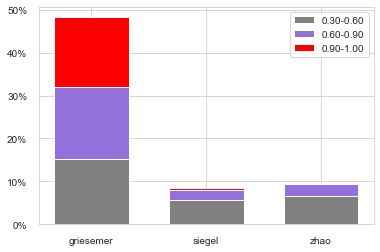

In [36]:
toplot4 = toplot.groupby('mpra')['prediction'].value_counts().to_frame(name = 'count').reset_index()
toplot4['fraction'] = toplot4.groupby('mpra')['count'].apply(lambda g: g/g.sum())
toplot4 = toplot4[toplot4['prediction']!='0-0.30']

bottom = np.array([0.0, 0.0, 0.0])

f, ax = plt.subplots()

bottom = np.array([0.0, 0.0, 0.0])
for prediction, color in zip(['0.30-0.60', '0.60-0.90', '0.90-1.00'], ['grey', 'mediumpurple', 'red']):
    temp = toplot4[toplot4['prediction']==prediction]
    print(temp)
    ax.bar(temp['mpra'].to_numpy(), temp['fraction'].to_numpy(), bottom = bottom,
          width = 0.65, label = prediction, color = color)
    
    bottom += temp['fraction'].to_numpy()

ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])    

ax.legend()

#f.savefig('Figures_ver3/Figure_7/Percent_of_predicted_spliced_reporters.pdf', transparent = True)

## Figure 5E:Splicing prediction and expression measurements

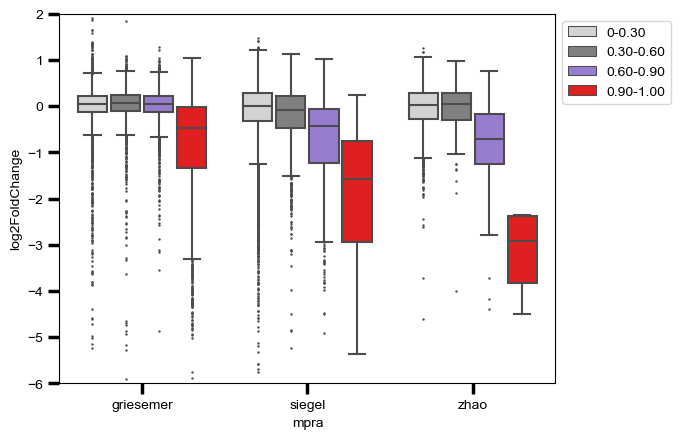

In [11]:
f, ax = plt.subplots()

sns.boxplot(
    data = toplot, 
    x = 'mpra', 
    y = 'log2FoldChange', 
    hue = 'prediction', 
    order = ['griesemer', 'siegel', 'zhao'],
    palette = ['lightgrey', 'grey', 'mediumpurple', 'red'],
    flierprops = {'marker': 'o', 'markersize': 0.75},
    ax = ax
)

ax.set_ylim(-6, 2)

adjust_box_widths(f, 0.90)

ax.legend(bbox_to_anchor = (1, 1))
#f.savefig('Figures_ver3/Figure_7/Figure_7_prediction_expression.pdf', transparent = True)

In [12]:
for df, mpra in zip([toplot1, toplot2, toplot3], ['Griesemer', 'Siegel', 'Zhao']):
    
    print(f'{mpra} MPRA')
    
    # Griesmer MPRA
    a = df[df['prediction']=='0-0.30']
    b = df[df['prediction']=='0.30-0.60']
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list(), nan_policy = 'omit')
    print(f'p value of 0-0.3 and 0.3-0.6 group is {p}')

    a = df[df['prediction']=='0-0.30']
    b = df[df['prediction']=='0.60-0.90']
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list(), nan_policy = 'omit')
    print(f'p value of 0-0.3 and 0.6-0.9 group is {p}')

    a = df[df['prediction']=='0-0.30']
    b = df[df['prediction']=='0.90-1.00']
    t, p = scipy.stats.mannwhitneyu(a['log2FoldChange'].to_list(), b['log2FoldChange'].to_list(), nan_policy = 'omit')
    print(f'p value of 0-0.3 and 0.9-1.0 group is {p}')

Griesemer MPRA
p value of 0-0.3 and 0.3-0.6 group is 8.081736990983717e-13
p value of 0-0.3 and 0.6-0.9 group is 0.6239492410105776
p value of 0-0.3 and 0.9-1.0 group is 0.0
Siegel MPRA
p value of 0-0.3 and 0.3-0.6 group is 1.630456158304791e-14
p value of 0-0.3 and 0.6-0.9 group is 8.754565971345094e-96
p value of 0-0.3 and 0.9-1.0 group is 2.805197798103207e-63
Zhao MPRA
p value of 0-0.3 and 0.3-0.6 group is 0.9663638231188951
p value of 0-0.3 and 0.6-0.9 group is 3.330497523982152e-18
p value of 0-0.3 and 0.9-1.0 group is 0.00011418201341688818


## Figure 5F: impact of splicing on Griesemer MPRA tamvar identification

In [13]:
# Convert dataframe to wide form
griesemer_splice = pd.pivot_table(
    griesemer_splice, 
    index = 'mpra_variant_id', 
    columns = 'allele', 
    values = 'probability'
)

# difference in splicing probability between alt and ref allele
griesemer_splice['delta'] = griesemer_splice['alt'] - griesemer_splice['ref']

# merge measurement from original publication with splicing prediction
merged = griesemer_result.merge(griesemer_splice, on = 'mpra_variant_id')

# Identify tamvars (statistically significant in at least 1 cell line)
tamvars = merged[(merged['padj_Skew_HEK293FT']<0.1)|
                (merged['padj_Skew_HEPG2']<0.1)|
                (merged['padj_Skew_HMEC']<0.1)|
                (merged['padj_Skew_K562']<0.1)|
                (merged['padj_Skew_GM12878']<0.1)|
                (merged['padj_Skew_SKNSH']<0.1)]

merged['tamvar'] = merged[
    'mpra_variant_id'
].apply(
    lambda g: 'tamvar' if g in tamvars['mpra_variant_id'].to_list() else 'nontamvar'
)

# divide reporters into 3 groups depending on difference in splicing probability
def bin_delta(delta):
    if delta < -0.35:
        return 'alt<ref'
    elif delta > 0.35:
        return 'alt>ref'
    else:
        return 'alt=ref'

    
merged['delta_bin'] = merged['delta'].apply(lambda g: bin_delta(g))

"alt>ref" and "alt=ref" groups p-value = 0.00403146337277174
"alt<ref" and "alt=ref" groups p-value = 0.00048379355415843344


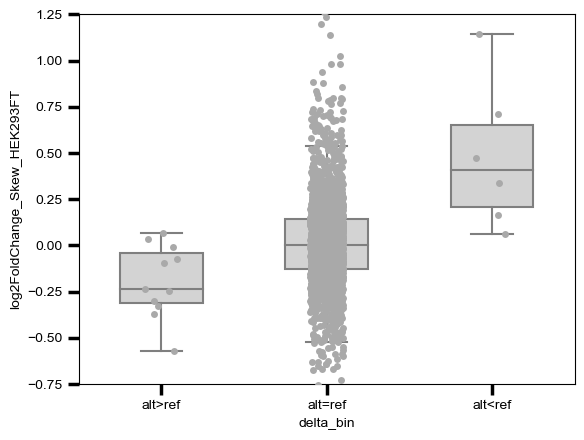

In [15]:
toplot = merged[merged['tamvar']=='tamvar']

f, ax = plt.subplots()

sns.boxplot(
    data = toplot, 
    x = 'delta_bin', 
    y = 'log2FoldChange_Skew_HEK293FT', 
    order = ['alt>ref', 'alt=ref', 'alt<ref'],
    color = 'lightgrey',
    width = 0.50,
    fliersize = 0, 
    ax = ax)

sns.stripplot(
    data = toplot, 
    x = 'delta_bin', 
    y = 'log2FoldChange_Skew_HEK293FT', 
    order = ['alt>ref', 'alt=ref', 'alt<ref'],
    color = 'darkgrey',
    ax = ax)

ax.set_ylim(-0.75, 1.25)

# t test between "alt>ref" and "alt=ref" group
a = toplot[toplot['delta_bin']=='alt>ref']
b = toplot[toplot['delta_bin']=='alt=ref']

t, p = scipy.stats.mannwhitneyu(a['log2FoldChange_Skew_HEK293FT'].to_list(), b['log2FoldChange_Skew_HEK293FT'].to_list(), nan_policy = 'omit')
print(f'"alt>ref" and "alt=ref" groups p-value = {p}')

# t test between "alt<ref" and "alt=ref" group
a = toplot[toplot['delta_bin']=='alt<ref']
b = toplot[toplot['delta_bin']=='alt=ref']

t, p = scipy.stats.mannwhitneyu(a['log2FoldChange_Skew_HEK293FT'].to_list(), b['log2FoldChange_Skew_HEK293FT'].to_list(), nan_policy = 'omit')
print(f'"alt<ref" and "alt=ref" groups p-value = {p}')

#f.savefig('Figures_ver3/Figure_7/Figure_7_Griesemer_comparison_v2.pdf', transparent = True)

## Figure S6B: spliceAI performance evaluation

In [21]:
# see "get_splice_site_rank.py" on how to generate this data
splice_site_rank = pd.read_csv('data/spliceAI_splice_site_rank.csv', sep = '\t')

# if a reporter is 20% spliced or more
# check if spliceAI assign the observed donor and acceptor with the highest probability or not
# if yes -> correct prediction
# if no -> incorrect prediction

def evaluate_prediction(S_fraction, donor_rank, acceptor_rank):
    if S_fraction >= 0.20:
        if donor_rank <= 1:
            donor_acc = 'donor_rank_1_2'
        else:
            donor_acc = 'donor_rank_3+'
            
        if acceptor_rank <= 1:
            acceptor_acc = 'acceptor_rank_1_2'
        else:
            acceptor_acc = 'acceptor_rank_3+'
    else:
        donor_acc = 'not_spliced'
        acceptor_acc = 'not_spliced'
        
    return donor_acc, acceptor_acc

splice_site_rank['donor_acc'], splice_site_rank['acceptor_acc'] = zip(*splice_site_rank.apply(
                                                    lambda g: evaluate_prediction(
                                                        g['splicing_efficiency'], 
                                                        g['donor_rank'], 
                                                        g['acceptor_rank']), 
                                                    axis = 1
                                                        )
                                                         )

       site  correct  incorrect  correct_per  incorrect_per
0  acceptor     1088        102    91.428571       8.571429
1     donor     1131         59    95.042017       4.957983


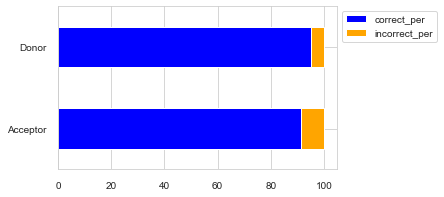

In [23]:
donor_correct_pred = len(splice_site_rank[splice_site_rank['donor_acc']=='donor_rank_1_2'])
donor_incorrect_pred = len(splice_site_rank[splice_site_rank['donor_acc']=='donor_rank_3+'])
acc_correct_pred = len(splice_site_rank[splice_site_rank['acceptor_acc']=='acceptor_rank_1_2'])
acc_incorrect_pred = len(splice_site_rank[splice_site_rank['acceptor_acc']=='acceptor_rank_3+'])

data = [
    ['acceptor', acc_correct_pred, acc_incorrect_pred],
    ['donor', donor_correct_pred, donor_incorrect_pred]
]

evaluation = pd.DataFrame(
    data, 
    columns = ['site', 'correct', 'incorrect']
)

evaluation['correct_per'] = evaluation['correct']*100/(evaluation['correct'] + evaluation['incorrect'])
evaluation['incorrect_per'] = evaluation['incorrect']*100/(evaluation['correct'] + evaluation['incorrect'])

print(evaluation)

sns.set_style("whitegrid")

f, ax = plt.subplots(figsize = (5, 3))

evaluation[['correct_per', 'incorrect_per']].plot.barh(
    stacked = True, 
    color = ['blue', 'orange'],
    ax = ax
)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Acceptor', 'Donor'])

ax.legend(bbox_to_anchor = (1, 1))

#f.savefig('Figures_current/spliceai_site_evaluation.pdf', transparent = True)

## Figure S6C: predicted location of donors and acceptors prediction

In [36]:
toplot1 = griesemer[griesemer['probability']>=0.30].reset_index(drop = True)
toplot1['start_norm'] = toplot1['start'] - 720
toplot1['end_norm'] = toplot1['end'] - 720
toplot1 = toplot1[['start_norm', 'end_norm']]
toplot1['mpra'] = 'griesemer'

toplot2 = siegel[siegel['probability']>=0.30].reset_index(drop = True)
toplot2['start_norm'] = toplot2['start'] - 720
toplot2['end_norm'] = toplot2['end'] - 720
toplot2 = toplot2[['start_norm', 'end_norm']]
toplot2['mpra'] = 'siegal'

toplot3 = zhao[zhao['probability']>=0.30].reset_index(drop = True)
toplot3['start_norm'] = toplot3['start'] - 720
toplot3['end_norm'] = toplot3['end'] - 720
toplot3 = toplot3[['start_norm', 'end_norm']]
toplot3['mpra'] = 'zhao'

toplot = pd.concat([toplot1, toplot2, toplot3]).reset_index(drop=True)
#toplot = toplot.astype({'start_norm': int})

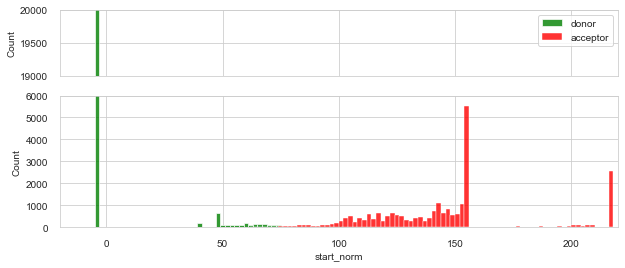

In [37]:
sns.set_style("whitegrid")

f, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10, 4), sharex = True, gridspec_kw={'height_ratios': [1, 2]})

sns.histplot(
    data = toplot, 
    x = 'start_norm', 
    binwidth = 2,
    color = 'green',
    label = 'donor',
    alpha = 0.8,
    ax = ax1
)

sns.histplot(
    data = toplot, 
    x = 'start_norm', 
    binwidth = 2, 
    color = 'green',
    alpha = 0.8,
    ax = ax2
)

sns.histplot(
    data = toplot, 
    x = 'end_norm', 
    binwidth = 2,
    label = 'acceptor',
    color = 'red',
    alpha = 0.8,
    ax = ax1
)

sns.histplot(
    data = toplot, 
    x = 'end_norm', 
    binwidth = 2, 
    color = 'red',
    alpha = 0.8,
    ax = ax2
)

ax1.set_xlim(-20, 220)
ax2.set_xlim(-20, 220)

ax1.set_ylim(19000, 20000)
ax2.set_ylim(0, 6000)

ax1.legend()

#f.savefig('Figures_current/donor_acceptor_location_spliceAI_prediction.pdf', transparent = True)

## Figure S7: Plot expression of validated variants

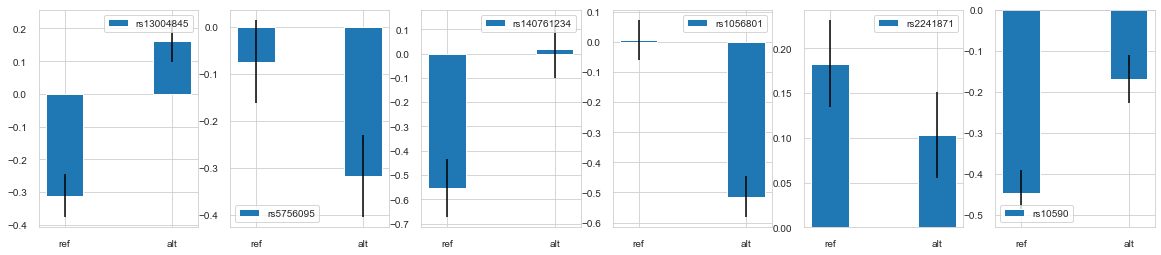

In [26]:
vars_to_plot = ['rs13004845', 'rs5756095', 'rs140761234', 'rs1056801', 'rs2241871', 'rs10590']

f, axs = plt.subplots(ncols = 6, figsize = (20, 4))

for var, ax in zip(vars_to_plot, axs):
    toplot = griesemer_result[griesemer_result['mpra_variant_id'].str.contains(var)]
    data = [toplot['log2FoldChange_Ref_HEK293FT'].values[0], toplot['log2FoldChange_Alt_HEK293FT'].values[0]]
    SE = [toplot['lfcSE_Ref_HEK293FT'].values[0], toplot['lfcSE_Alt_HEK293FT'].values[0]]
    
    ax.bar(['ref', 'alt'], data, width = 0.35, yerr = SE, label = var)
    ax.legend()

#f.savefig('Figures_ver3/Figure_7_rs10590_allele_comparison.pdf', transparent = True)